# Clifford Volume Benchmark – Tutorial

This notebook walks through how to:
1. Build a **CliffordVolumeBenchmark**
2. Generate benchmark circuits
3. Simulate them with Qiskit Aer
4. Attach results and evaluate


## Setup

In [10]:
import numpy as np
from ScalableVolumetricBenchmark import CliffordVolumeBenchmark
from qiskit import QuantumCircuit as QiskitCircuit
from qiskit_aer import AerSimulator


from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError, pauli_error

## Create benchmark

In [3]:
n_qubits = 5
sample_size = 25
shots = 2048

benchmark = CliffordVolumeBenchmark(
    number_of_qubits=n_qubits,
    sample_size=sample_size,
    format="qasm2",
    target_sdk="qiskit",
    shots=shots,
    auto_save=False,
)
benchmark.create_benchmark()
benchmark

CliffordVolumeBenchmark(
  benchmark_id='clifford_nq5_s25_20251125T135501_5705711c',
  number_of_qubits=5,
  sample_size=25,
  format='qasm2',
  target_sdk='qiskit',
  workdir=WindowsPath('.benchmarks'),
)

## Simulate circuits

In [4]:
simulator = AerSimulator()
counts_data = {}

for sample in benchmark.samples:
    for circuit in sample["circuits"]:
        cid = circuit["circuit_id"]
        qasm = circuit["qasm"]
        qk_circ = QiskitCircuit.from_qasm_str(qasm)
        job = simulator.run(qk_circ, shots=benchmark.shots)
        result = job.result()
        counts = result.get_counts()
        remapped = {b[::-1]: int(c) for b, c in counts.items()}
        counts_data[cid] = remapped

len(counts_data)

250

## Attach results

In [5]:
benchmark.add_experimental_results(
    counts_data,
    experiment_id="qiskit_aer_clifford_demo",
    platform="qiskit-aer",
    experiment_metadata={"backend": "AerSimulator"},
)
benchmark.experimental_results.keys()

dict_keys(['experiment_id', 'platform', 'experiment_metadata', 'results'])

## Evaluate benchmark

In [13]:
evaluation = benchmark.evaluate_benchmark(auto_save=False)

ValueError: No experimental_results attached. Call add_experimental_results(...) first.

## Plot

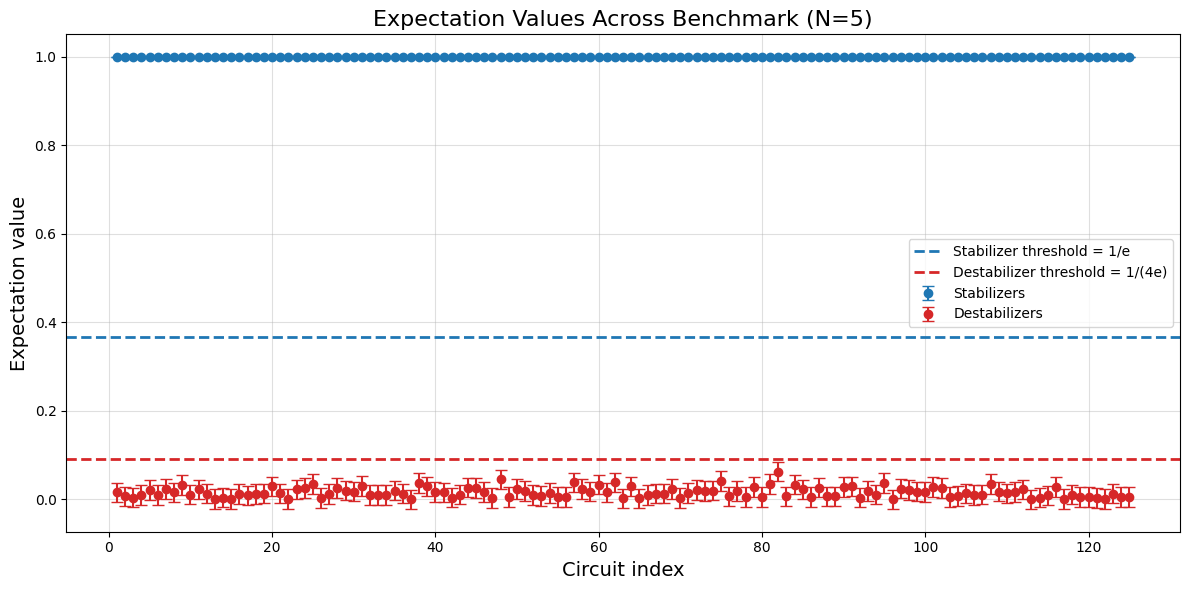

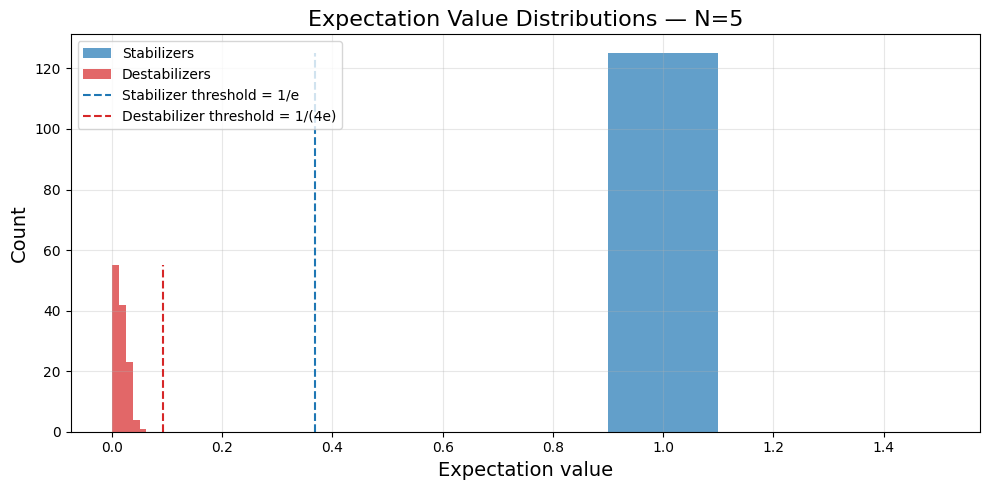

In [7]:
benchmark.plot_all_expectation_values()
benchmark.plot_expectation_histograms(bins=5)

## Use noise simulator

In [11]:
number_of_qubits = 10

cm = CouplingMap.from_line(num_qubits=number_of_qubits)
noise_model = NoiseModel()
cx_depolarizing_prob = 0.001 # two qubit depolarization error
p_r = 0.001 # for uncorrelated bit-flip readout error

noise_model.add_all_qubit_quantum_error(depolarizing_error(cx_depolarizing_prob, 2), ["cx"]) # cnot depolarization error
noise_model.add_all_qubit_quantum_error(pauli_error([('X',p_r), ('I', 1 - p_r)]), "measure") # simple readout bitflip error

basis_gates=['cx', 'rx', 'ry', 'ry', 'p']

ideal_backend = AerSimulator(basis_gates=basis_gates)
ideal_pass_manager = generate_preset_pass_manager(optimization_level=3, basis_gates=['cx', 'rx', 'ry', 'ry', 'p'])

noisy_backend = AerSimulator(noise_model=noise_model, basis_gates=basis_gates)
noisy_pass_manager = generate_preset_pass_manager(optimization_level=3, basis_gates=['cx', 'rx', 'ry', 'ry', 'p'])

In [12]:
n_qubits = 5
sample_size = 10
shots = 2048

benchmark = CliffordVolumeBenchmark(
    number_of_qubits=n_qubits,
    sample_size=sample_size,
    format="qasm2",
    target_sdk="qiskit",
    shots=shots,
    auto_save=True,
    workdir='test'
)
benchmark.create_benchmark()
benchmark

[Benchmark] Saved to: test\clifford_nq5_s10_20251125T135717_b91c125a.json


CliffordVolumeBenchmark(
  benchmark_id='clifford_nq5_s10_20251125T135717_b91c125a',
  number_of_qubits=5,
  sample_size=10,
  format='qasm2',
  target_sdk='qiskit',
  workdir=WindowsPath('test'),
)

In [15]:
counts_data = {}

for sample in benchmark.samples:
    for circuit in sample["circuits"]:
        cid = circuit["circuit_id"]
        qasm = circuit["qasm"]
        qk_circ = QiskitCircuit.from_qasm_str(qasm)
        job = noisy_backend.run(noisy_pass_manager.run(qk_circ), shots=benchmark.shots)
        result = job.result()
        counts = result.get_counts()
        remapped = {b[::-1]: int(c) for b, c in counts.items()}
        counts_data[cid] = remapped

len(counts_data)

100

In [18]:
benchmark.add_experimental_results(
    counts_data,
    experiment_id="qiskit_aer_clifford_demo",
    platform="qiskit-aer",
    experiment_metadata={"backend": "AerSimulator", "noise_model" : "two_qubit_depolarization"},
)
benchmark.experimental_results.keys()

[Benchmark] Saved to: test\clifford_nq5_s10_20251125T135717_b91c125a.json


dict_keys(['experiment_id', 'platform', 'experiment_metadata', 'results'])

In [20]:
evaluation = benchmark.evaluate_benchmark()


 Clifford Benchmark Evaluation (5 qubits)

Stabilizer expectation values:
  • average: 0.979844 ± 0.007457
  • lowest measured value: 0.964844

Destabilizer expectation values:
  • average: -0.000742 ± 0.019243
  • highest absolute value: 0.048828

Benchmark passed: True



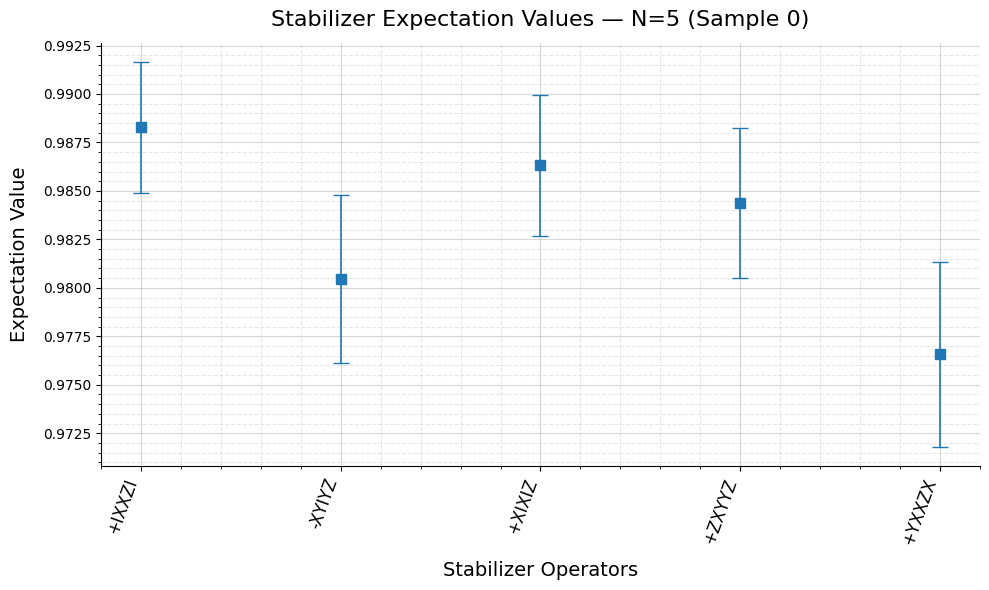

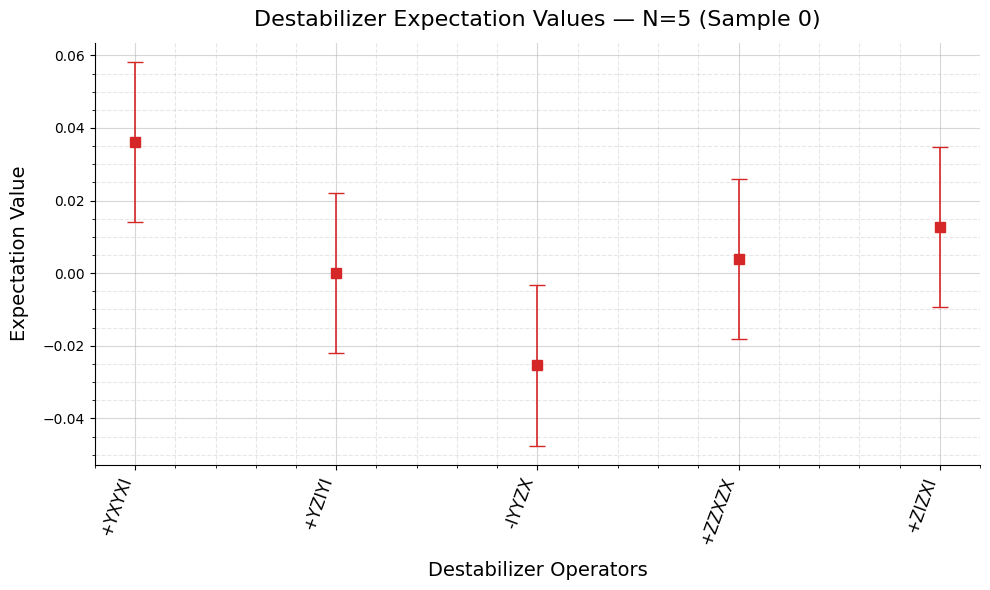

In [23]:
benchmark.plot_expected_values(0)

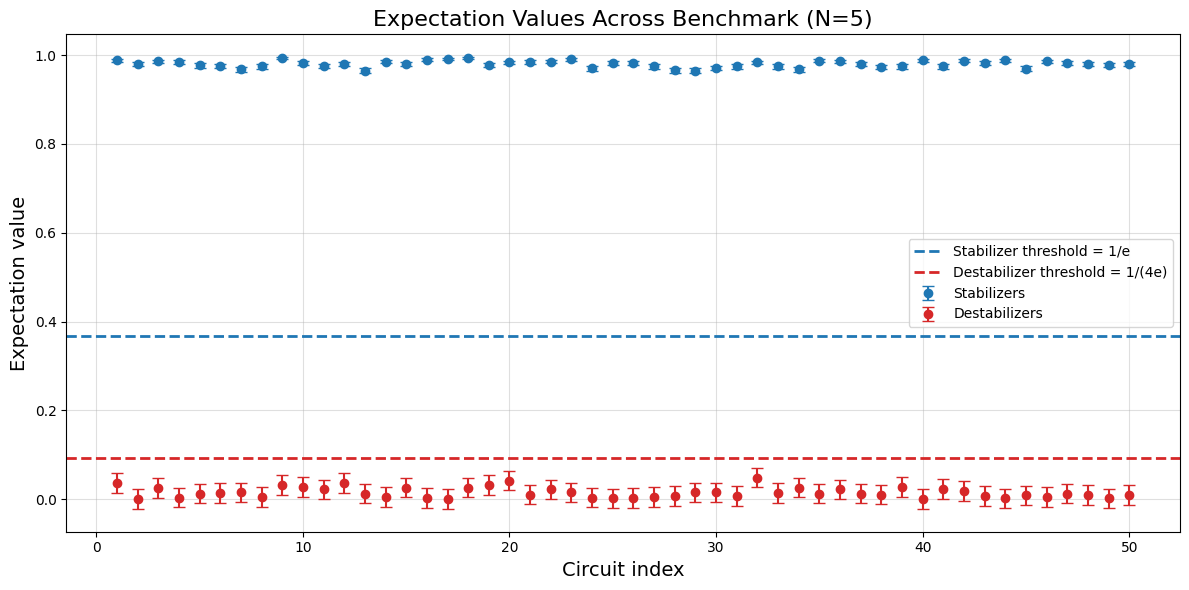

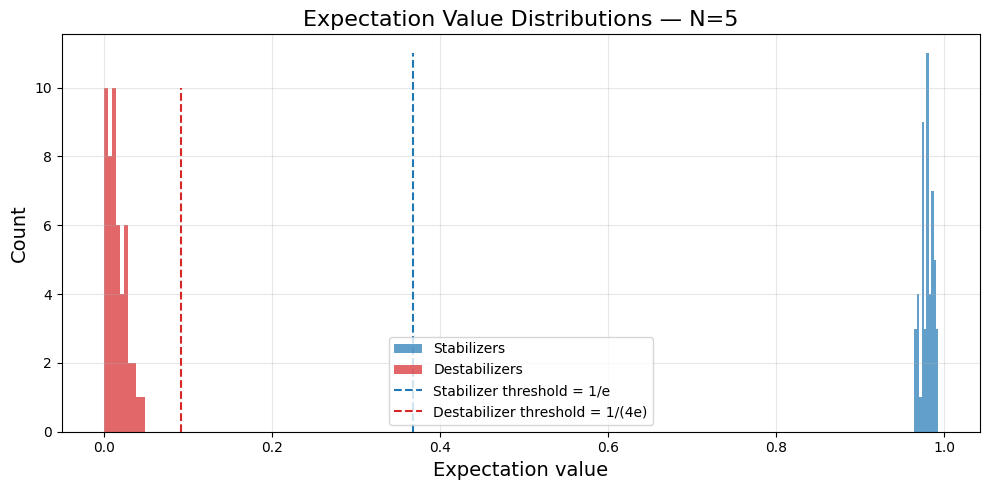

In [24]:
benchmark.plot_all_expectation_values()
benchmark.plot_expectation_histograms(bins=10)